For the last two questions regarding what are related to relationships of variables with salary and job satisfaction - Each of these questions will involve not only building some sort of predictive model, but also finding and interpretting the influential components of whatever model we build.

To get started let's read in the necessary libraries and take a look at some of our columns of interest.

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

df = pd.read_csv('./survey_results_public.csv')
df.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
# Working with just quantitative variables is actually pretty straightforward 
# for most supervised learning techniques (except - we note that any row with 
# a missing value in any of the columns we use will be dropped -
# which might leave us with fewer predictions than we were hoping for).
# Let's just start and iterate on our findings

# Let's just fit something and go from there
df.describe()

,Respondent,CareerSatisfaction,JobSatisfaction,HoursPerWeek,StackOverflowSatisfaction,Salary,ExpectedSalary
count,51392.000000,42695.000000,40376.000000,20600.000000,36592.000000,12891.000000,2566.000000
mean,25696.500000,7.300574,6.957078,3.952282,8.429875,56298.480641,33142.220468
std,14835.736854,1.955444,2.167652,7.564722,1.390635,39880.905277,30162.988829
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12848.750000,6.000000,6.000000,1.000000,8.000000,26440.371839,4490.492484
50%,25696.500000,8.000000,7.000000,1.000000,9.000000,50000.000000,29364.263691
75%,38544.250000,9.000000,8.000000,4.000000,10.000000,80000.000000,50403.225806
max,51392.000000,10.000000,10.000000,40.000000,10.000000,197000.000000,187500.000000


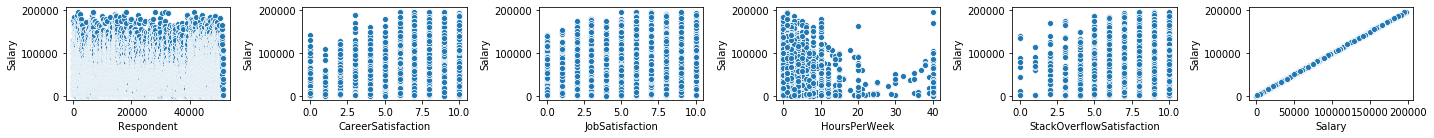

In [49]:
# The above are variables that python is treating as numeric variables, and therefore, we 
# could send them into our linear model blindly to predict the response
# Let's take a quick look at our data first
num_vars = df.select_dtypes(exclude='object').copy()

fig = plt.figure(figsize=(20,2))
for index in range(len(num_vars.columns)-1):
    plt.subplot(1,6,index+1)
    sns.scatterplot(x=num_vars.iloc[:,index], y='Salary', data=num_vars)
fig.tight_layout(pad=1.0)

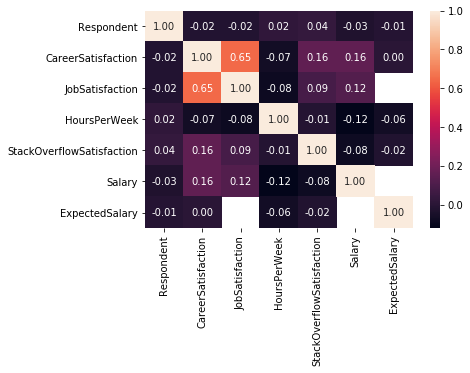

In [25]:
sns.heatmap(df.corr(), annot=True, fmt=".2f");

The Salary and the ExpectedSalary do never appear in the same row. Thus the 'ExpectedSalary' cannot be straightforwardly used to predict the acutal 'Salary'. Thus we would proceed by removing this feature.

In [50]:
num_vars.drop(columns = 'ExpectedSalary', inplace = True )

# Screencasts Remaining:
1. Imputation - first results
2. Categorical Variables - improved results, but what is happening?
3. Combat Overfitting - one method

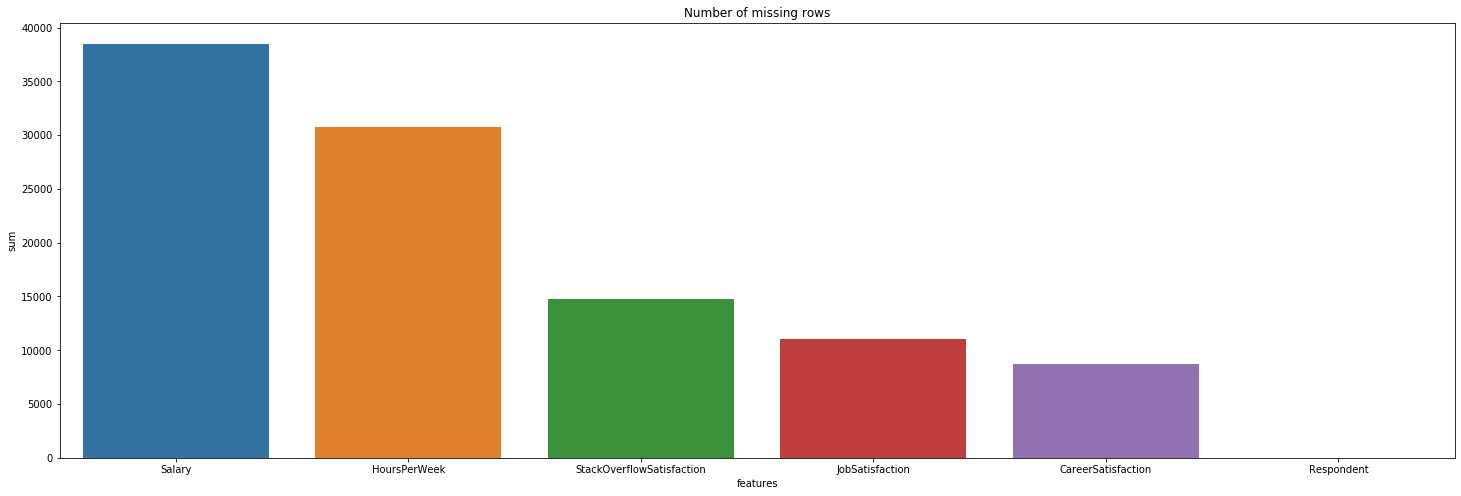

In [51]:
#Here we fill on the column means
plt.figure(figsize=(25,8))
plt.title('Number of missing rows')
missing_count = pd.DataFrame(num_vars.isnull().sum(), columns=['sum']).sort_values(by=['sum'],ascending=False).head(20).reset_index()
missing_count.columns = ['features','sum']
sns.barplot(x='features',y='sum', data = missing_count)


We would drop the entries with missing Salary as this is the target variable. 

In [27]:
num_vars = num_vars.dropna(subset=['Salary'])
df_fillna = num_vars.apply(lambda x: x.fillna(x.mean()),axis=0)

X = df_fillna[['CareerSatisfaction', 'HoursPerWeek', 'JobSatisfaction', 'StackOverflowSatisfaction']]
y = df_fillna['Salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

lm_model = LinearRegression(normalize=True) 
lm_model.fit(X_train, y_train) 
        
y_test_preds = lm_model.predict(X_test) 

print(r2_score(y_test, y_test_preds))

0.04072431792894726


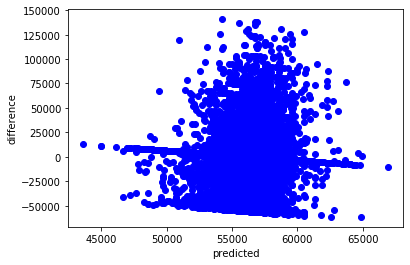

In [28]:
plt.plot(preds_vs_act['preds'], preds_vs_act['diff'], 'bo');
plt.xlabel('predicted');
plt.ylabel('difference');

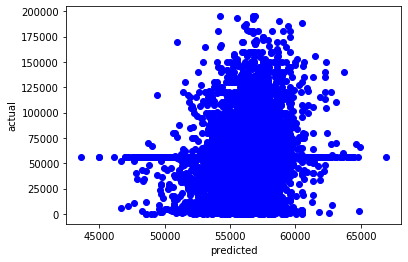

In [29]:
### When we see fan like shapes in the residual plots like this - it often suggests
### we might make better predictions on the log of the response

plt.plot(preds_vs_act['preds'], preds_vs_act['actual'], 'bo');
plt.xlabel('predicted');
plt.ylabel('actual'); #there appears to be a slight positive trend like we would want to see

In [30]:
cat_vars_int = df.select_dtypes(include=['object']).copy().columns
# http://pbpython.com/categorical-encoding.html
len(cat_vars_int)

147

In [31]:
for var in  cat_vars_int:
    # for each cat add dummy var, drop original column
    df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)

df.describe()

,Respondent,CareerSatisfaction,JobSatisfaction,HoursPerWeek,StackOverflowSatisfaction,Salary,ExpectedSalary,Professional_Professional developer,Professional_Professional non-developer who sometimes writes code,Professional_Student,...,QuestionsInteresting_Strongly agree,QuestionsInteresting_Strongly disagree,QuestionsConfusing_Disagree,QuestionsConfusing_Somewhat agree,QuestionsConfusing_Strongly agree,QuestionsConfusing_Strongly disagree,InterestedAnswers_Disagree,InterestedAnswers_Somewhat agree,InterestedAnswers_Strongly agree,InterestedAnswers_Strongly disagree
count,51392.000000,42695.000000,40376.000000,20600.000000,36592.000000,12891.000000,2566.000000,51392.000000,51392.000000,51392.000000,...,51392.000000,51392.000000,51392.000000,51392.000000,51392.000000,51392.000000,51392.000000,51392.000000,51392.000000,51392.000000
mean,25696.500000,7.300574,6.957078,3.952282,8.429875,56298.480641,33142.220468,0.703047,0.100016,0.160025,...,0.056371,0.004942,0.407748,0.062656,0.003191,0.184795,0.019303,0.084274,0.278720,0.007044
std,14835.736854,1.955444,2.167652,7.564722,1.390635,39880.905277,30162.988829,0.456920,0.300024,0.366633,...,0.230638,0.070129,0.491421,0.242345,0.056401,0.388135,0.137588,0.277801,0.448374,0.083633
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12848.750000,6.000000,6.000000,1.000000,8.000000,26440.371839,4490.492484,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,25696.500000,8.000000,7.000000,1.000000,9.000000,50000.000000,29364.263691,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38544.250000,9.000000,8.000000,4.000000,10.000000,80000.000000,50403.225806,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,51392.000000,10.000000,10.000000,40.000000,10.000000,197000.000000,187500.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [25]:


### Because we have more rows than number of variables, it is actually possible
### for us to build a model that uses all of the columns to predict the response...
### Whether this is actually a good idea or not is up for debate - let's maybe
### choose some variables that seem like they might be related to salary and go from there.

### You can also see that the nulls are still dropped after dummy encoding, which means
### we will again need to figure out what to do with rows where those values are null.
### It might be okay to just use the mode of the dataset to fill in those values - though
### in reality, a lack of answer is maybe an indication that your answer is different 
### from the group and therefore, you didn't want to answer the question.

### We know there are 12891 non-NaN salaries to predict based on the previous model - so we
### want to make sure we can predict all of these salaries with our new model as well, but now
### unlike the 5 columns we had to choose from before we have more than 40,000 to choose from.
### This could be a great place for some PCA or PLS, but I would like to try and keep 
### the interpretability of the features as much as possible... so I am just going to
### use the original features. 

### We could try even adding interactions or other combinations of these features, but again
### this would make our features less interpretable. So you have to weigh the pros and cons
### of adding these features.

In [26]:
df_result = pd.concat([df, df_fillna], axis=1, join='inner')
df_result.shape

(12891, 42347)

In [27]:
df_result['Salary'].head()['Salary']

,Salary,Salary
2,113750.0,113750.0
14,100000.0,100000.0
17,130000.0,130000.0
18,82500.0,82500.0
22,100764.0,100764.0


In [28]:
df_result = df_result.iloc[:,~df_result.columns.duplicated()]

In [29]:
df_result.shape

(12891, 42342)

In [30]:
### Now we have no duplicated columns, we can focus on which of our new columns (and the 
### previously used columns) we would like to use to try and predict the response.  We might
### just go based on intuition, or we could try to find the variables that are most correlated
### Don't get too high of hopes - having a quant variable correlated with a 1-0 variable
### is not really what correlation coefficients are designed to detect.  They are meant
### to find linear relationships between quant variables. Though correlations are not built for
### finding these relations - they can still give a sense of which variables are best related


### Actually if you try to build the correlation matrix... it might run for a long time, and
### not be very legible anyway... Let's just fit some stuff that seems interesting 
### and intuitive.

In [31]:
### Given how many columns we have to use - let's just drop all of the columns that have any
### missing values

df_result = df_result.dropna(axis=1, how='any')

In [32]:
df_result.shape # which is only 6, sooo that kind of sucks at narrowing down this mess...

(12891, 42336)

In [34]:
y = df_result['Salary']
X = df_result.drop(['Respondent', 'Salary'], axis=1)

In [35]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

#lm_model = LinearRegression(normalize=True) # Here you could set any hyperparameters of your model
#lm_model.fit(X_train, y_train) # If this model was to predict for new individuals, we probably would want
               # worry about train/test splits and cross-validation, but for now I am most 
               # interested in finding a model that just fits all of the data well

        
#y_test_preds = lm_model.predict(X_test) #We can then use our fitted model to predict the salary for each
                                        #indvidual in our test set, and see how well these predictions
                                        #match the truth.

#print(r2_score(y_test, y_test_preds)) #In this case we are predicting a continuous, numeric response.  Therefore, common
#print(mean_squared_error(y_test, y_test_preds)) #metrics to assess fit include Rsquared and MSE.  
## Filling in the missing values does appear to have helped based on a preliminary check


In [36]:
#print(r2_score(y_train, lm_model.predict(X_train)))
#print(mean_squared_error(y_train, lm_model.predict(X_train))) # What does this mean?

To combat the overfitting we have a number of options, but one way that would also reduce our run time would be to remove columns from our dataframe.  You will notice that sklearn does not provide pvals back for our coefficients, but it performs ridge regression by default.  So, therefore, we can consider that columns that have larger coefficients are also more useful for predicting our response variable.  How large is large enough to consider keeping? Well, that is a great question, and I also don't have a great answer...  We can try some stuff and see what works. 

Then we can also run cross-validation and aggregate our results to combat the overfitting we saw earlier using this reduced X matrix.

In [62]:
# You could deal with these rare events in different ways - you could consider them as great predictors
# I am going to remove them - as I feel like they are likely not that indicative of other individuals
# I want to find overriding truths about the individuals who receive particular salaries.
# So, let's only consider columns where there are more than 1000 of the level of interest in the column.

reduce_X = X.iloc[:, np.where((X.sum() > 10) == True)[0]]
reduce_X.shape

(12891, 2637)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = .30, random_state=42)

lm_model = LinearRegression(normalize=True) # Here you could set any hyperparameters of your model
lm_model.fit(X_train, y_train) # If this model was to predict for new individuals, we probably would want
               # worry about train/test splits and cross-validation, but for now I am most 
               # interested in finding a model that just fits all of the data well

        
y_test_preds = lm_model.predict(X_test) #We can then use our fitted model to predict the salary for each
                                        #indvidual in our test set, and see how well these predictions
                                        #match the truth.

print(r2_score(y_test, y_test_preds)) #In this case we are predicting a continuous, numeric response.  Therefore, common
print(mean_squared_error(y_test, y_test_preds)) #metrics to assess fit include Rsquared and MSE.  
## Filling in the missing values does appear to have helped based on a preliminary check

0.674976343389
503572469.281


In [64]:
print(r2_score(y_train, lm_model.predict(X_train))) #In this case we are predicting a continuous, numeric response.  Therefore, common
print(mean_squared_error(y_train, lm_model.predict(X_train))) #metrics to assess fit include Rsquared and MSE.  
## Filling in the missing values does appear to have helped based on a preliminary check

0.838856972216
259108335.391


In [84]:
### Let's see what be the best number of features to use based on the test set performance
def find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result
    
    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:
        
        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True) 
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)
        
        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)
    
    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()
        
    best_cutoff = max(results, key=results.get)
    
    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression(normalize=True) 
    lm_model.fit(X_train, y_train)
        
    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test

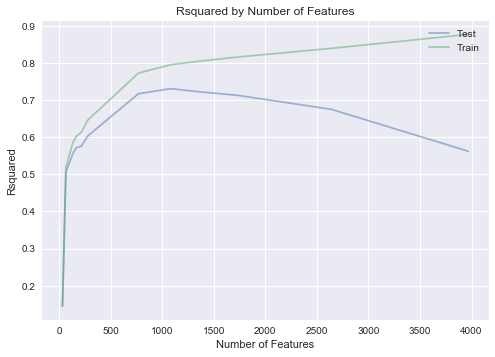

In [81]:
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 20, 10, 5]
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs)

In [82]:
#______Video 4 Creating Dummy Variables & Other Alternatives for Categorical Variables____#




### Now that we have the best model in terms of the r2 on the test data, we can use this model to see which features
### appear to be most important, and what impact they have on salary.

X_train.shape # we have 1081 features in the optimal model - let's look at some of them


(9023, 1081)

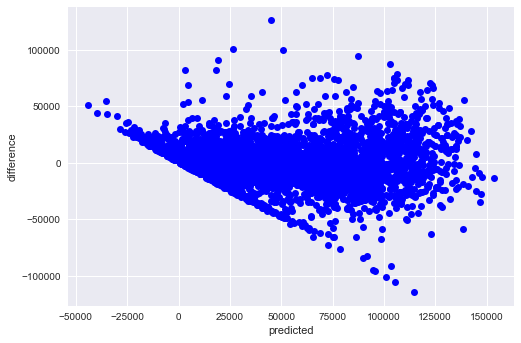

In [96]:
y_test_preds = lm_model.predict(X_test)

preds_vs_act = pd.DataFrame(np.hstack([y_test.values.reshape(y_test.size,1), y_test_preds.reshape(y_test.size,1)]))
preds_vs_act.columns = ['actual', 'preds']
preds_vs_act['diff'] = preds_vs_act['actual'] - preds_vs_act['preds']

plt.plot(preds_vs_act['preds'], preds_vs_act['diff'], 'bo');
plt.xlabel('predicted');
plt.ylabel('difference');

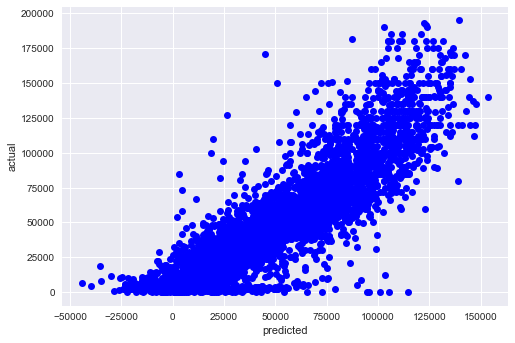

In [97]:
plt.plot(preds_vs_act['preds'], preds_vs_act['actual'], 'bo');
plt.xlabel('predicted');
plt.ylabel('actual'); #there appears to be a slight positive trend like we would want to see

In [122]:
coefs_df = pd.DataFrame()

coefs_df['est_int'] = X_train.columns
coefs_df['coefs'] = lm_model.coef_
coefs_df['abs_coefs'] = np.abs(lm_model.coef_)

coefs_df.sort_values('abs_coefs', ascending=False).head(20)

,est_int,coefs,abs_coefs
0,Professional_Professional developer,3.668536e+18,3.668536e+18
39,Country_United States,5.690911e+04,5.690911e+04
25,Country_Norway,4.020815e+04,4.020815e+04
5,Country_Australia,4.018075e+04,4.018075e+04
380,Currency_Swiss francs,3.683437e+04,3.683437e+04
12,Country_Denmark,3.018176e+04,3.018176e+04
24,Country_New Zealand,2.996317e+04,2.996317e+04
20,Country_Israel,2.964533e+04,2.964533e+04
10,Country_Canada,2.962889e+04,2.962889e+04
120,YearsCodedJob_20 or more years,2.960331e+04,2.960331e+04


In [116]:
lm_model.intercept_

-3.6685360312259738e+18

In [118]:
X_train.shape, sum(X_train['Professional_Professional developer'])


#_____Video 7 Interpretting the results_____#

((9023, 1081), 9023)

In [146]:
#____Video 8 - Ensemble Models______#

### One of the best out of the box methods for supervised machine learning
### is known as the RandomForest - let's see if we can use this model to outperform
### The linear model from earlier.

from sklearn.ensemble import RandomForestRegressor

### Let's see what be the best number of features to use based on the test set performance
def find_optimal_rf_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result
    kwargs - include the arguments you want to pass to the rf model
    
    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    rf_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:
        
        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response

        rf_model = RandomForestRegressor()  #no normalizing here, but could tune other hyperparameters
        rf_model.fit(X_train, y_train)
        y_test_preds = rf_model.predict(X_test)
        y_train_preds = rf_model.predict(X_train)
        
        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)
    
    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()
        
    best_cutoff = max(results, key=results.get)
    
    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    rf_model = RandomForestRegressor() 
    rf_model.fit(X_train, y_train)
        
    return r2_scores_test, r2_scores_train, rf_model, X_train, X_test, y_train, y_test

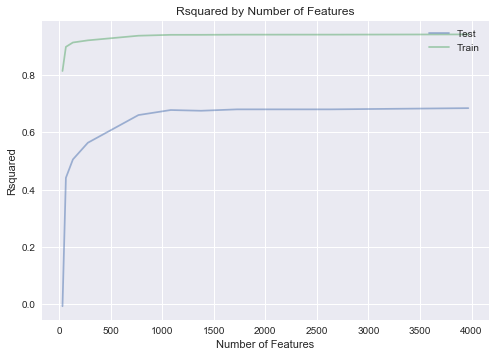

In [147]:
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 20, 10, 5]
r2_test, r2_train, rf_model, X_train, X_test, y_train, y_test = find_optimal_rf_mod(X, y, cutoffs)

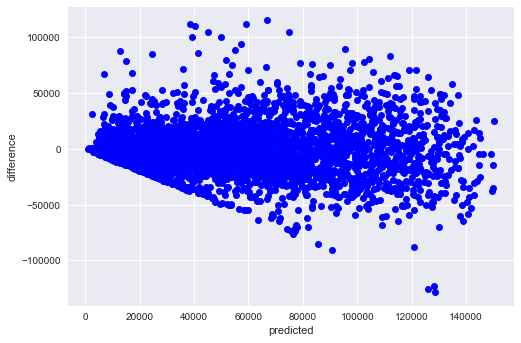

In [135]:
y_test_preds = rf_model.predict(X_test)

preds_vs_act = pd.DataFrame(np.hstack([y_test.values.reshape(y_test.size,1), y_test_preds.reshape(y_test.size,1)]))
preds_vs_act.columns = ['actual', 'preds']
preds_vs_act['diff'] = preds_vs_act['actual'] - preds_vs_act['preds']

plt.plot(preds_vs_act['preds'], preds_vs_act['diff'], 'bo');
plt.xlabel('predicted');
plt.ylabel('difference');

In [148]:
#Looks like this overfits quite a bit... 

In [157]:
from sklearn.model_selection import GridSearchCV

### Let's see what be the best number of features to use based on the test set performance
def find_optimal_rf_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True, param_grid=None):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result
    kwargs - include the arguments you want to pass to the rf model
    
    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    rf_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''

    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        if param_grid==None:
            rf_model = RandomForestRegressor()  #no normalizing here, but could tune other hyperparameters

        else:
            rf_inst = RandomForestRegressor(n_jobs=-1, verbose=1)
            rf_model = GridSearchCV(rf_inst, param_grid, n_jobs=-1) 
            
        rf_model.fit(X_train, y_train)
        y_test_preds = rf_model.predict(X_test)
        y_train_preds = rf_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()
        
    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    if param_grid==None:
        rf_model = RandomForestRegressor()  #no normalizing here, but could tune other hyperparameters

    else:
        rf_inst = RandomForestRegressor(n_jobs=-1, verbose=1)
        rf_model = GridSearchCV(rf_inst, param_grid, n_jobs=-1) 
    rf_model.fit(X_train, y_train)
     
    return r2_scores_test, r2_scores_train, rf_model, X_train, X_test, y_train, y_test

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  42 tasks     

[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   10.5s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   12.9s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192

[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   38.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   30.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   37.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks 

[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jo

[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.0min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks  

[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 442 tasks  

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_job

[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   24.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  5.9min
[P

[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   30.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   30.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 1

[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 792 

[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.3s finished


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.6min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks    

[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 23.8min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Done  4

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.3s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.4s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.5s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:

[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 14.4min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Done 1000 out of 

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.5s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   55.5s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks 

[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   29.9s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   32.2s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   28.6s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.

[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   59.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.1min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.0min finished
[Parallel(n_jobs=4)]: Done  42 

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 32.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 31.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 30.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 40.7min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    2.0s 

[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.7min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks    

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.6min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 19.7min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 20.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.0min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: D

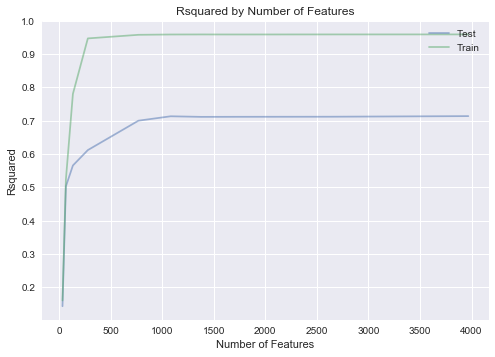

In [159]:
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 20, 10, 5]
params = {'n_estimators': [10, 100, 1000], 'max_depth': [1, 5, 10, 100]}
r2_test, r2_train, rf_model, X_train, X_test, y_train, y_test = find_optimal_rf_mod(X, y, cutoffs, param_grid=params)

[0.1434832190870845,
 0.50312830555464327,
 0.56587007612084017,
 0.61209835688773562,
 0.70037336638014969,
 0.71357758463021015,
 0.71179914641488184,
 0.71200015668392846,
 0.71225551954795407,
 0.71407567064339428]